<center><img src="kontur.jpg"></center>

Для выполнения тестового задания требуется разработать модель, которая будет способна различать заголовки реальных и выдуманных новостей.
Для обучения модели используйте данные из файла `train.tsv`. В файле находится таблица, состоящая из двух колонок. 
В колонке title записан заголовок новости. В колонке is_fake содержатся метки: 0 – новость реальная; 1 – новость выдуманная.
Для демонстрации работы модели используйте данные тестового набора из файла `test.tsv`. В нем также есть колонка title, данные которой являются входными для вашей модели.
Вам нужно скопировать файл `test.tsv`, переименовать его в `predictions.tsv` и заполнить колонку is_fake значениями предсказаний вашей модели, аналогично `train.tsv`. 
Изначально колонка заполнена значением 0.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
import re
import string
from string import punctuation

In [3]:
#!pip install pymorphy2
#!pip install navec
#!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar

In [4]:
#импорт полезных функций из отдельного python файла
from utils import cnt_upper_words,prep_quotas,has_quota_clause,has_person,tense,cnt_verbs
from utils import count_punc,remove_stopwords,stemmer,lemmer,has_country,politics,word_to_norm_to_vector

In [5]:
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
import catboost
import xgboost

In [52]:
train = pd.read_csv("dataset/train.tsv",sep="\t")
test = pd.read_csv("dataset/test.tsv",sep="\t")
test_title = test["title"]

<b>Использование функций для отчистки текстовых признаков. И создание новых признаков: количество слов в разметке, количество символов, наличие страны, количество глаголов, время предложения, количество ковычек и тд., которые извлекаются из title.</b>

In [7]:
def add_features(df:pd.DataFrame)->pd.DataFrame:
    df["cnt_upper_words"], df["cnt_upper_char"] = zip(*df['title'].map(cnt_upper_words))
    df["cnt_quoted_words"], df["cnt_quoted_chars"] = zip(*df["title"].map(prep_quotas))
    df["title"] = df["title"].apply(lambda x:x.lower())
    df["cnt_quota_claus"] = df["title"].apply(has_quota_clause)   
    df["n_words"] = df["title"].apply(lambda x:len(x.split()))
    df["n_chars"] = df["title"].apply(lambda x:len(x))
    df["amount_punc"] = df["title"].apply(count_punc)
    df["title"] = df["title"].apply(lambda x: x.split())   
    df['title']= df['title'].apply(lambda x:remove_stopwords(x))
    df["title"] = df["title"].apply(lambda x: [i.strip("«»:") for i in x])  
    df["cnt_verbs"] = df["title"].apply(cnt_verbs)
    df["tense"] = df["title"].apply(tense)
    df = pd.concat((df,pd.get_dummies(df.tense,prefix="tense_cat",drop_first=True)),axis=1).drop("tense",1)
    return df

#достаются признаки после лемматизации и приведении слов в начальную форму
def add_features_after_lemm(df):
    df['title'] = df['title'].apply(lambda x: lemmer(x))
    df["has_country"] = df["title"].apply(has_country)
    df["politics"] = df["title"].apply(politics)
    df["has_person"] = df["title"].apply(has_person)
    return df

In [8]:
train = add_features(train)
train = add_features_after_lemm(train)
test = add_features(test)
test = add_features_after_lemm(test)

<b>Доля выдуманных заголовков в датасете.</b>

In [9]:
train["is_fake"].mean()

0.5

<b>Средние значения новых признаков, группированных по is_fake. Можно посмотреть насколько отличаются эти значения.</b>

In [10]:
train.groupby("is_fake").mean().T

is_fake,0,1
cnt_upper_words,0.217089,0.250434
cnt_upper_char,0.701980,0.867315
cnt_quoted_words,0.101424,0.241403
cnt_quoted_chars,1.035429,5.054533
cnt_quota_claus,0.089614,0.218826
n_words,7.353595,10.093783
n_chars,53.798541,76.454672
amount_punc,0.156999,0.555054
cnt_verbs,1.081626,1.303925
tense_cat_1,0.042376,0.074331


<b>Можно заметить, что в выдуманных заголовках намного чаще упоминаются различные политики, а также больше количество слов/символов. Тense_cat_1 - настоящее время, tense_cat_2 - прошедшее время,tense_cat_3 - будущее, предложения с будущем временем чаще употребляется в фейковом классе. Количество пунктуации сильно отличается. Сравнивать признаки проще визуализацией, поэтому построю несколько графиков особенно отличающихся признаков.</b>

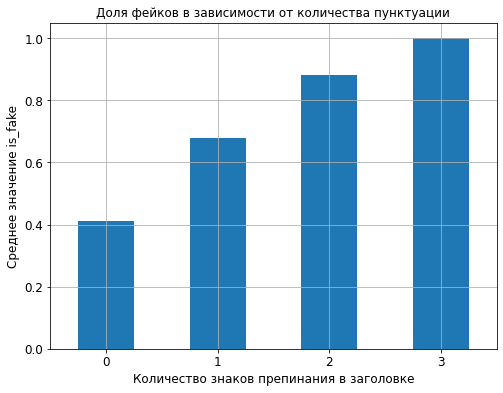

In [11]:
df_agg = train.groupby("amount_punc")["is_fake"].agg(["count","mean"]).round(2)
plt.figure(figsize=(8,6))
df_agg.loc[df_agg["count"]>50]["mean"].plot.bar(rot=0,fontsize=12,title="Доля фейков в зависимости от количества пунктуации",grid=True)
plt.xlabel("Количество знаков препинания в заголовке",fontsize=12)
plt.ylabel("Среднее значение is_fake",fontsize=12);

In [12]:
df_agg = train.groupby("politics")["is_fake"].agg(["count","mean"]).round(2)
df_agg.loc[df_agg["count"]>20]

,count,mean
politics,,
0,5426,0.48
1,306,0.85
2,26,0.96


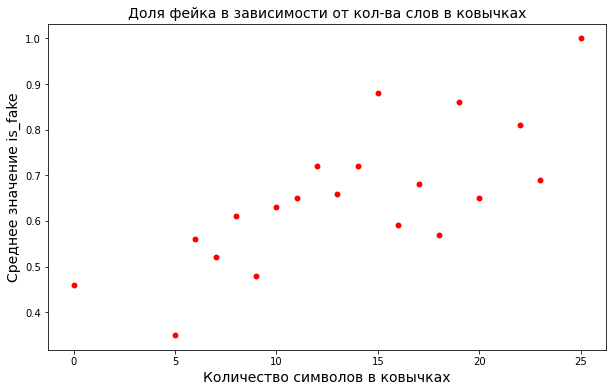

In [13]:
df_agg = train.groupby("cnt_quoted_chars")["is_fake"].agg(["count","mean"]).round(2)
plt.figure(figsize=(10,6))
sns.scatterplot(x=df_agg.loc[df_agg["count"]>15].index,y=df_agg.loc[df_agg["count"]>15]["mean"],color="red",linewidth=0.1)
plt.ylabel("Среднее значение is_fake",fontsize=14)
plt.xlabel("Количество символов в ковычках",fontsize=14)
plt.title("Доля фейка в зависимости от кол-ва слов в ковычках",fontsize=14);

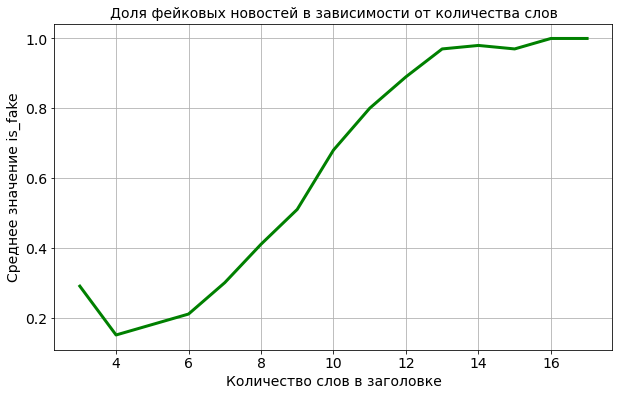

In [14]:
df_agg = train.groupby("n_words")["is_fake"].agg(["count","mean"]).round(2)
df_agg.loc[df_agg["count"]>10]["mean"].plot(figsize=(10,6),linewidth=3,color="green",grid=True,fontsize=14)
plt.title("Доля фейковых новостей в зависимости от количества слов",fontsize=14)
plt.xlabel("Количество слов в заголовке",fontsize=14)
plt.ylabel("Среднее значение is_fake",fontsize=14);

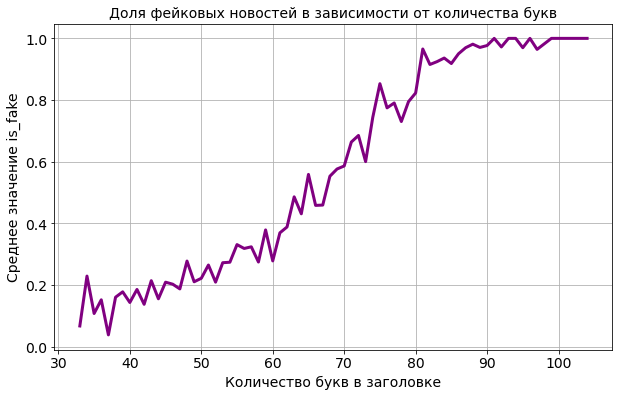

In [15]:
df_agg = train.groupby("n_chars")["is_fake"].agg(["count","mean"])
df_agg[df_agg["count"]>20]["mean"].plot(figsize=(10,6),linewidth=3,color="purple",grid=True,fontsize=14)
plt.title("Доля фейковых новостей в зависимости от количества букв",fontsize=14)
plt.xlabel("Количество букв в заголовке",fontsize=14)
plt.ylabel("Среднее значение is_fake",fontsize=14);

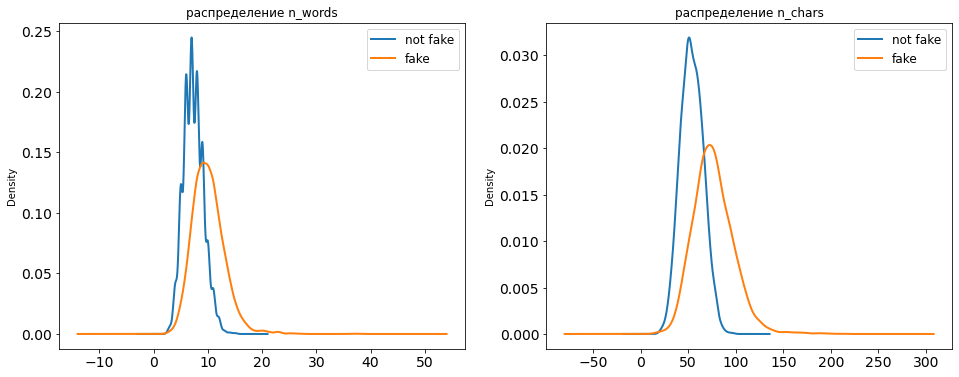

In [16]:
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(16,6))
train.groupby("is_fake")["n_words"].plot(kind="kde",ax=axes[0],title="распределение n_words",linewidth=2,fontsize=14)
train.groupby("is_fake")["n_chars"].plot(kind="kde",ax=axes[1],title="распределение n_chars",linewidth=2,fontsize=14)
axes[0].legend(["not fake","fake"],fontsize=12)
axes[1].legend(["not fake","fake"],fontsize=12);

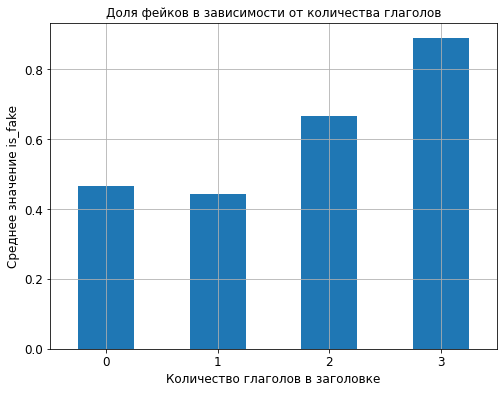

In [17]:
df_agg = train.groupby("cnt_verbs")["is_fake"].agg(["count","mean"])
plt.figure(figsize=(8,6))
ax = df_agg[df_agg["count"]>20]["mean"].plot.bar(rot=0,title="Доля фейков в зависимости от количества глаголов",fontsize=12,grid=True)
plt.xlabel("Количество глаголов в заголовке",fontsize=12)
plt.ylabel("Среднее значение is_fake",fontsize=12);

<b>Появление любого политика/противоречивой личности в заголовке повышает вероятность того, что это обман. Доля фейков растет с количеством символов в ковычках, вероятно из-за "придуманных" высказываний каких либо людей (политиков). Интересно, что при количестве символов 80+ заметно увеличивается доля (среднее значение) таргета. И распределение кол-ва символов или слов выдуманных заголовков выглядит очень странно (возможно сгенерированные моделью синтетические данные, а не придуманные людьми).</b>

In [18]:
# функция для кросс-валидации (с подсчетом  f1_score)
def cvs(model, data:pd.DataFrame, y:pd.Series, n_splits=5, thresh=0.5) -> pd.DataFrame:
    train_score = np.array([])
    test_score = np.array([])
    kf = KFold(n_splits=n_splits,shuffle=True,random_state=4)
    for train_idx,test_idx in kf.split(data):
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        train, test = data.iloc[train_idx],data.iloc[test_idx]
        model.fit(train,y_train)
        train_pred = np.where(model.predict(train)<thresh,0,1)
        test_pred = np.where(model.predict(test)<thresh,0,1)
        train_score = np.append(train_score,f1_score(train_pred,y_train))
        test_score = np.append(test_score,f1_score(test_pred,y_test))
    f1_scores = pd.DataFrame({"f1_train":train_score,"f1_test":test_score})
    return f1_scores

In [19]:
X = train.drop("is_fake",1)
y = train["is_fake"]

In [20]:
cvs(LinearRegression(),X.drop(["title"],1),y)

,f1_train,f1_test
0,0.769517,0.775435
1,0.772936,0.762264
2,0.770158,0.759588
3,0.770571,0.764045
4,0.766316,0.784101


<b>Линейная регрессия без главного признака title уже дается не такой плохой результат f1 = 0.77.</b>

In [21]:
X["title"] = X["title"].apply(lambda x: " ".join(x))
test["title"] = test["title"].apply(lambda x: " ".join(x))

In [22]:
cvs(catboost.CatBoostClassifier(silent=True,text_features=["title"]),X,y,3)

,f1_train,f1_test
0,0.955083,0.883915
1,0.955177,0.876393
2,0.950785,0.885878


<b>Градиентный бустинг без подкрученных гиперпараметров с использованием текстовых признаков даёт приличный результат (0.88). Препроцессинг для title - bag of words.</b>

In [23]:
# преобразование слов в их векторные представления и дальнейшее усреднее эмбеддингов
word2vec_train = X["title"].apply(word_to_norm_to_vector)
word2vec_test = test["title"].apply(word_to_norm_to_vector)

In [24]:
word2vec_train = word2vec_train.apply(pd.Series)
word2vec_test = word2vec_test.apply(pd.Series)

In [25]:
full_df_train = pd.concat([word2vec_train,X],axis=1)
full_df_test = pd.concat([word2vec_test,test],axis=1)

In [26]:
full_df_train.shape, full_df_test.shape

((5758, 316), (1000, 317))

<b>Результат бустинга xgboost с ембедингами f1 = 0.85, но без title. Тоже без подбора гиперпараметров.</b>

In [27]:
model = xgboost.XGBClassifier()

In [28]:
cvs(model,full_df_train.drop("title",1),y,3)

,f1_train,f1_test
0,1.0,0.864488
1,1.0,0.842558
2,1.0,0.855372


<b>Можно посмотреть на признаки, которые xgboost посчитал особенно важными.</b>

In [29]:
model.fit(full_df_train.drop("title",1),y);

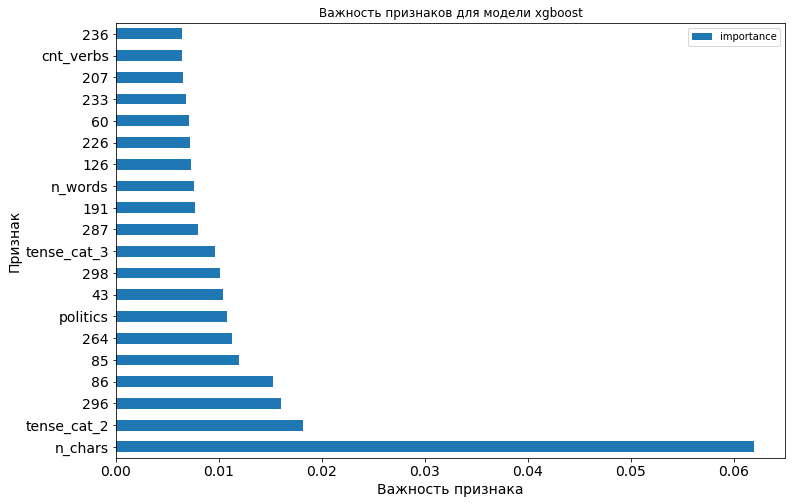

In [30]:
features = pd.DataFrame(model.feature_importances_,index = full_df_train.drop("title",1).columns,columns = ["importance"])
features.sort_values(by="importance",ascending=False).head(20).plot.barh(fontsize=14,title="Важность признаков для модели xgboost",figsize=(12,8))
plt.xlabel("Важность признака",fontsize=14)
plt.ylabel("Признак",fontsize=14);

<b>Прошедшее время и количество символов в заголовке в топе. По графикам выше как раз видно, почему у n_chars наибольшая важность.</b>

In [31]:
cvs(catboost.CatBoostClassifier(silent=True,text_features=["title"]),full_df_train,y,5)

,f1_train,f1_test
0,0.992580,0.917165
1,0.991775,0.885590
2,0.990646,0.892200
3,0.990513,0.898836
4,0.990129,0.885444


<b>Нейросети - один из самых популярных методов для работы с текстом. </b>

In [32]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential,Model
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D,Dropout,BatchNormalization
from keras.layers.merge import concatenate
import tensorflow as tf
from keras import backend as K

In [33]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [34]:
# необходимая предобработка для title
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(X['title'].values)
X_train_text = tokenizer.texts_to_sequences(X['title'].values)
X_train_text = pad_sequences(X_train_text,maxlen=16)
test_text = tokenizer.texts_to_sequences(test['title'].values)
test_text = pad_sequences(test_text,maxlen=16)

<b>Архитектура состоит из двух входов: 1 - признаки извлеченные из текста + эмбеддинги, 2 - токенизированный признак title. По первому пути обучаются нейроны с нормализацией, а по второму lstm, дальше они сливаются и делают прогноз. Использовал мало количество нейронов, слабую регуляризацию и в общем легкую структуру, так как данных очень мало, нет нужды усложнять.</b>

In [35]:
# 2 входа
input_1 = tf.keras.Input(shape=(16))
input_2 = tf.keras.Input(shape=(315))


# для токенизированного title
emb_1 = Embedding(max_fatures, 64)(input_1)
spat_1 = SpatialDropout1D(0.3)(emb_1)
lstm_1 = LSTM(32, dropout=0.2, recurrent_dropout=0.2)(spat_1)
#dense_1 = Dense(8,kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-4, l2=1e-4))(lstm_1)

# для признаков + эмбеддинги 
dense_2_1 = Dense(32,kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-4, l2=1e-4))(input_2)
batch_2 = BatchNormalization()(dense_2_1)
drop_2 = Dropout(0.3)(batch_2)

# объединение
merge = concatenate([lstm_1, drop_2])

dense_3 = Dense(8,kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-4, l2=1e-4))(merge)
drop_3 = Dropout(0.2)(dense_3)

output = Dense(1, activation="sigmoid")(drop_3)

model = Model(inputs = [input_1,input_2], outputs = output, name="fake_model")

model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001,momentum=0.2),
    metrics=[f1,tf.keras.metrics.AUC()]
)

model.summary()

Model: "fake_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 16)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 315)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 16, 64)       128000      ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 32)           10112       ['input_2[0][0]']                
                                                                                         

In [36]:
history = model.fit(x = [X_train_text,full_df_train.drop(["title"],1)], y = y, epochs = 50, batch_size=32,validation_split = 0.25, verbose = 0)

In [37]:
history = pd.DataFrame(history.history)

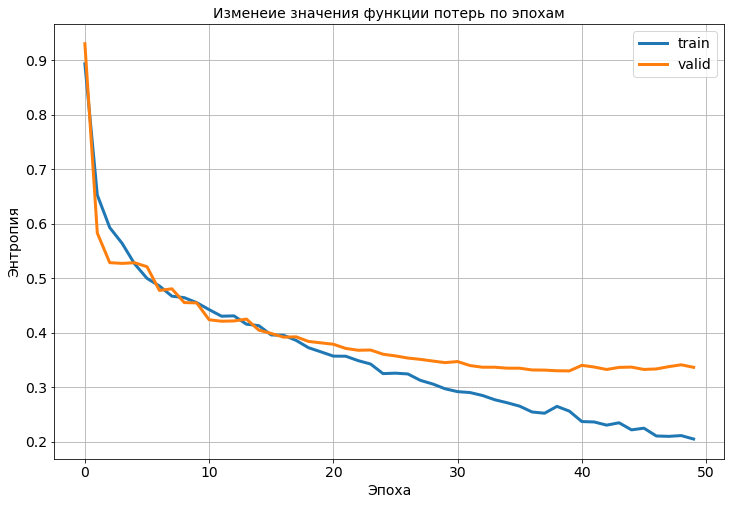

In [38]:
history[["loss","val_loss"]].plot(fontsize=14,figsize=(12,8),linewidth=3,grid=True)
plt.title("Изменеие значения функции потерь по эпохам",fontsize=14)
plt.xlabel("Эпоха",fontsize=14)
plt.ylabel("Энтропия",fontsize=14)
plt.legend(["train","valid"],fontsize=14);

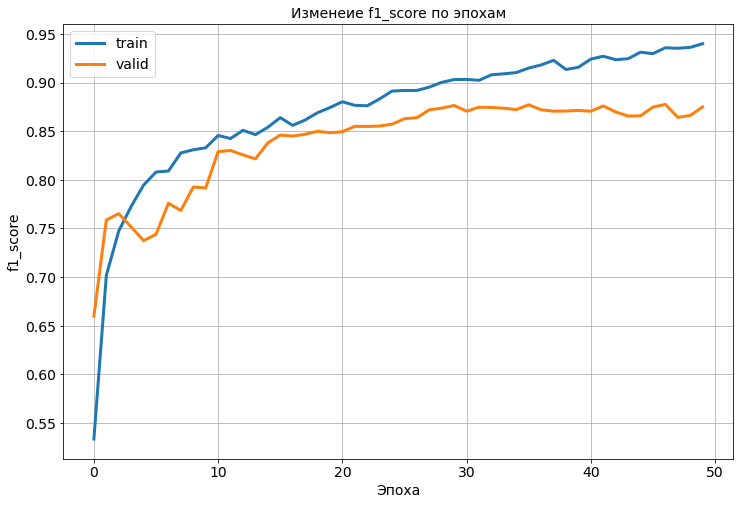

In [39]:
history[["f1","val_f1"]].plot(grid=True,fontsize=14,figsize=(12,8),linewidth=3)
plt.title("Изменеие f1_score по эпохам",fontsize=14)
plt.xlabel("Эпоха",fontsize=14)
plt.ylabel("f1_score",fontsize=14)
plt.legend(["train","valid"],fontsize=14);

In [40]:
print("Лучший результат f1 на валидационной выборке =",round(history["val_f1"].max(),2))

Лучший результат f1 на валидационной выборке = 0.88


In [63]:
print("Лучший результат roc_auc на валидационной выборке =",round(history["val_auc"].max(),3))

Лучший результат roc_auc на валидационной выборке = 0.954


<b>Лучший результат f1 = 0.88, что лучше xgboost, но всё еще хуже catboost.</b>

In [41]:
model = catboost.CatBoostClassifier(silent=True,text_features=["title"])
model.fit(full_df_train,y)
prediction = model.predict(full_df_test)

In [64]:
pd.DataFrame({"title":test_title,"is_fake":prediction}).to_csv("predictions.tsv",sep="\t",index=False)

In [65]:
pd.read_csv("predictions.tsv",sep="\t").head()

,title,is_fake
0,Роскомнадзор представил реестр сочетаний цвето...,1
1,Ночью под Минском на президентской горе Белара...,1
2,Бывший спичрайтер Юрия Лозы рассказал о трудно...,1
3,"Сельская церковь, собравшая рекордно низкое ко...",1
4,Акции Google рухнули после объявления о переза...,0


In [66]:
print("Доля выдуманных заголовков новостей в тестовом датасете",round(prediction.mean(),3))

Доля выдуманных заголовков новостей в тестовом датасете 0.485


In [45]:
print("Версия библиотеки sklearn = """,sklearn.__version__)
print("Версия библиотеки pandas = ",pd.__version__)
print("Версия библиотеки tensorflow = ",tf.__version__)
print("Версия библиотеки catboost = ",catboost.__version__)
print("Версия библиотеки xgboost = ",xgboost.__version__)

Версия библиотеки sklearn =  0.23.2
Версия библиотеки pandas =  1.1.2
Версия библиотеки tensorflow =  2.7.0
Версия библиотеки catboost =  1.0.5
Версия библиотеки xgboost =  1.2.0


Интересными закономерностями обладает датасет, безусловно много чего ещё можно сделать: более подброно посмотреть, изучить данные, построить другие сложные модели. Однако результаты полученные моделью catboost, как мне кажется, вполне достаточно. F1_score = 0.88 без подобранных гиперпараметров является довольно хорошим результатом.   
Результаты, которые получились в ходе выполнения задания:    

 |**модель**|**признаки**|**f1**|
|---|---|---|
|LR|базовые признаки|0.77|
|catboost|базовые признаки+title|0.88|
|xgboost|базовые признаки+эмбеддинги|0.85|
|**catboost**|**базовые признаки+эмбеддинги+title**|**0.89**|
|nn+rnn|базовые признаки+эмбеддинги+title|0.88|

Есть несколько способов улучшить результат:
1. Извлечь/создать ещё много интересных признаков, например, с помощью pymorphy или регулярных выражений
2. Найти гиперпараметры для бустинга, использововав hyperopt/optuna.
3. Наути другие общедоступные, предобученные эмбеддинги. Не усреднять векторы слов в заголовке, а как-то иначе предобработать.
4. Найти другие более подходящие архитектуры нейросети.
5. Использовать более сложные подходы (BERT).   

Данных довольно мало, всего лишь ~6 тыс. строк, этого может быть не достаточно для модели, чтобы в полной силе работать. Больший датасет позволит получить лучшие результат. 